In [1]:
### If Google Colab
# !git config --global user.email "sjs.shamsi@gmail.com"
# !git config --global user.name "SJShamsi"

# from google.colab import drive
# drive.mount('/content/drive')

# Thesis_Files = '/content/drive/MyDrive/Thesis_Files/'

Sometimes our lightcurves have very small differences in cadence, and we need to fix that.

In [2]:
### Importing common items
base_directory = '/home/shoaib/ZTFDataChallenge/'

import sys
sys.path.insert(0, base_directory + 'dmdt_Analysis/')
from dmdt_functions import *

import random
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas(desc="Lightcurves Processed")

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=10)

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 4)

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.style.use('seaborn-v0_8-colorblind')
# plt.rcParams['axes.grid'] = False

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
lightcurves_by_name = pd.read_pickle(base_directory + 'lightcurves_by_name.pkl')
### Sampling to save memory
# lightcurves_by_name = lightcurves_by_name.sample(frac=0.1)

lightcurves_by_oid = pd.read_pickle(base_directory + 'lightcurves_by_oid.pkl')
### Sampling to save memory
# lightcurves_by_oid = lightcurves_by_oid.sample(frac=0.1)

## At What times in the day do most observations take place?

In [4]:
t_min, t_max = np.inf, -np.inf

for index, row in lightcurves_by_name.dropna(axis=0).iterrows():
    earliest_mjd = min(row['r_lightcurve'][:, 0][0], row['g_lightcurve'][:, 0][0])
    latest_mjd = max(row['r_lightcurve'][:, 0][-1], row['g_lightcurve'][:, 0][-1])
    
    if earliest_mjd < t_min:
        t_min = earliest_mjd
    if latest_mjd > t_max:
        t_max = latest_mjd

print(f'The earliest MJD is {t_min} and the latest MJD is {t_max}.')

The earliest MJD is 58197.2604282 and the latest MJD is 59331.5037616.


Lightcurves Processed:   0%|          | 0/32231 [00:00<?, ?it/s]

Lightcurves Processed:   0%|          | 0/32231 [00:00<?, ?it/s]

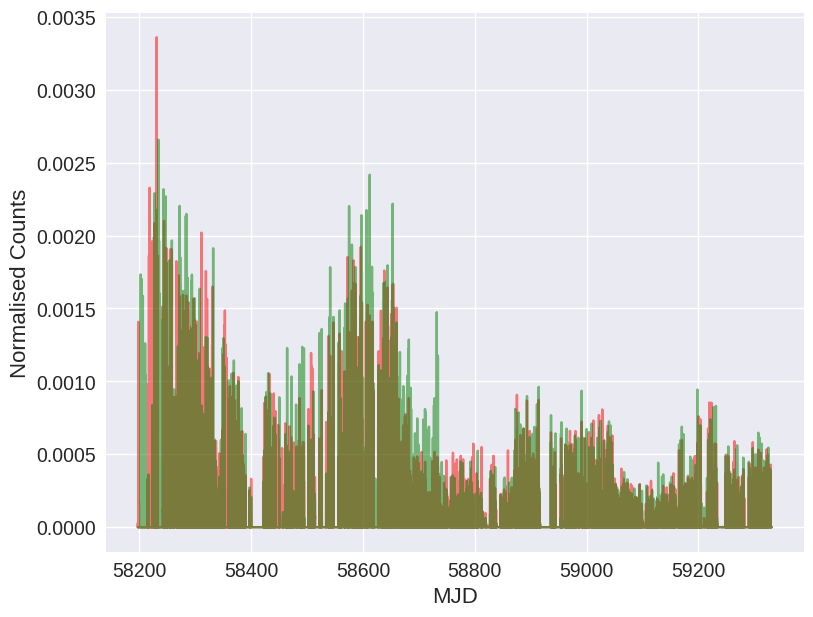

In [5]:
mjd_bins = np.arange(t_min, t_max, 1 / 24) # bins every hour
mjd_bins_midpoints = (mjd_bins[:-1] + mjd_bins[1:]) / 2

r_mjd_hist_tot = lightcurves_by_name['r_lightcurve'].progress_apply(lambda lc: np.histogram(a=lc[:, 0], bins=mjd_bins)[0] if isinstance(lc, np.ndarray) else np.nan).sum()
g_mjd_hist_tot = lightcurves_by_name['g_lightcurve'].progress_apply(lambda lc: np.histogram(a=lc[:, 0], bins=mjd_bins)[0] if isinstance(lc, np.ndarray) else np.nan).sum()

plt.figure(figsize=(9, 7))

plt.plot(mjd_bins_midpoints, r_mjd_hist_tot / r_mjd_hist_tot.sum(), alpha=0.5, color='r')
plt.plot(mjd_bins_midpoints, g_mjd_hist_tot / g_mjd_hist_tot.sum(), alpha=0.5, color='g')

plt.xlabel('MJD', size=16)
plt.ylabel('Normalised Counts', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.show()

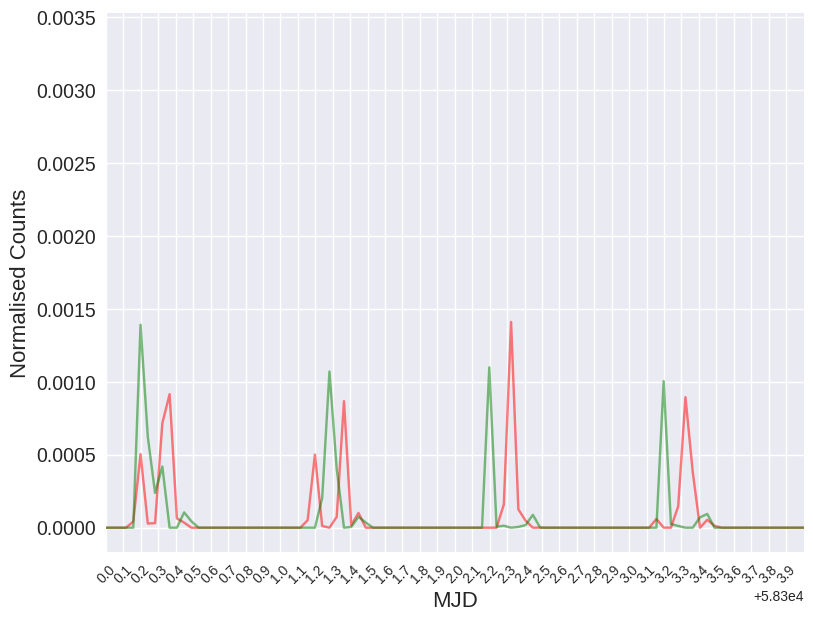

In [6]:
plt.figure(figsize=(9, 7))

plt.plot(mjd_bins_midpoints, r_mjd_hist_tot / r_mjd_hist_tot.sum(), alpha=0.5, color='r')
plt.plot(mjd_bins_midpoints, g_mjd_hist_tot / g_mjd_hist_tot.sum(), alpha=0.5, color='g')

plt.xlabel('MJD', size=16)
plt.ylabel('Normalised Counts', size=16)
plt.yticks(size=14)

mjd_xmin, mjd_xmax = 58300, 58304
plt.xlim(mjd_xmin, mjd_xmax)
plt.xticks(np.arange(mjd_xmin, mjd_xmax, 0.1), rotation=45)

plt.show()

Okay, so now we know what kind of times to avoid when binning across MJDs.

## Binning the Lightcurves

In [7]:
def lightcurve_binner(bins, mjd_array, magnitude_array, err_magnitude_array):
    binned_mjd = []
    binned_magnitude = []
    binned_err_magnitude = []
    
    bin_indices = np.digitize(mjd_array, bins)
    
    for i in range(1, len(bins)):
        mask = bin_indices == i
        if np.any(mask):
            weights = 1 / err_magnitude_array[mask]**2

            mean_mjd = np.mean(mjd_array[mask])
            weighted_magnitude = np.average(magnitude_array[mask], weights=weights)
            combined_err_magnitude = np.sqrt(1 / weights.sum())

            binned_mjd.append(mean_mjd)
            binned_magnitude.append(weighted_magnitude)
            binned_err_magnitude.append(combined_err_magnitude)
    
    binned_mjd = np.array(binned_mjd)
    binned_magnitude = np.array(binned_magnitude)
    binned_err_magnitude = np.array(binned_err_magnitude)
    return np.column_stack((binned_mjd, binned_magnitude, binned_err_magnitude))

def apply_dayscale_binning(interval, lightcurve):
    if not isinstance(lightcurve, np.ndarray):
        return np.nan
    mjd_array = lightcurve[:, 0]
    magnitude_array = lightcurve[:, 1]
    err_magnitude_array = lightcurve[:, 2]
    bins = np.arange(int(mjd_array.min()), np.ceil(mjd_array.max()), interval)
    
    binned_lightcurve = lightcurve_binner(bins, mjd_array, magnitude_array, err_magnitude_array)
    if binned_lightcurve.shape[0] < 2:
        return np.nan
    return binned_lightcurve

In [8]:
def plot_single_subfig(subfig, r_original_lightcurve, g_original_lightcurve, r_binned_lightcurve, g_binned_lightcurve, title):
    subfig.suptitle(title, size=16, y=0.94)
    
    axs = subfig.subplots(nrows=1, ncols=2, sharey=True)
    draw_lightcurve(ax=axs[0], band='r', lightcurve=r_original_lightcurve)
    draw_lightcurve(ax=axs[0], band='g', lightcurve=g_original_lightcurve)

    draw_lightcurve(ax=axs[1], band='r', lightcurve=r_binned_lightcurve)
    draw_lightcurve(ax=axs[1], band='g', lightcurve=g_binned_lightcurve)

    return axs

In [9]:
qso_types = ['Q', 'QR', 'QX']

### Lightcurves by Object

In [10]:
lightcurves_by_name

,name,type,ra,dec,z,g_timespan_good,g_n_good_det,g_oids,g_lightcurve,r_timespan_good,r_n_good_det,r_oids,r_lightcurve
0,1AXG J000605+2031,AX,1.497482,20.523582,0.38,964.688067,229.0,"[550110200005509, 550110200005509, 55011020000...","[[58268.4661921, 17.2914085, 0.0193178076], [5...",981.708229,222.0,"[550210200011033, 550210200011033, 55021020001...","[[58268.4470486, 17.2935829, 0.0198369212], [5..."
1,1AXG J035008-1149,AX,57.522460,-11.824012,0.45,376.989526,10.0,"[1344109100000968, 1345112200001061, 134410910...","[[58390.4113657, 19.8996181, 0.129595727], [58...",340.960799,6.0,"[1344209100007817, 1344209100007817, 134521220...","[[58432.3809954, 19.886844600000003, 0.1277610..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32229,eHAQ0142+0257,QR,25.528603,2.953628,2.31,957.648796,214.0,"[450107400003174, 450107400003174, 45010740000...","[[58298.4827431, 18.9552612, 0.063075698899999...",962.719190,342.0,"[450207400009426, 450207400009426, 45020740000...","[[58301.4430787, 17.906868, 0.0333674327], [58..."
32230,eHAQ0147+1549,BRX,26.820357,15.828883,0.37,959.672581,416.0,"[553101400000952, 554104300001475, 55310140000...","[[58300.4637847, 19.7455463, 0.107512668], [58...",982.677836,886.0,"[553201400001883, 554204300001931, 55320140000...","[[58288.4649769, 18.7370911, 0.060006402400000..."


#### 1 Day Cadence Light Curves

In [11]:
interval = 1 # days

lightcurves_by_name['r_lightcurve_1day'] = lightcurves_by_name['r_lightcurve'].parallel_apply(lambda lc: apply_dayscale_binning(interval, lc))
lightcurves_by_name['r_n_good_det_1day'] = lightcurves_by_name['r_lightcurve_1day'].apply(lambda lc: lc.shape[0] if isinstance(lc, np.ndarray) else np.nan)
lightcurves_by_name['r_timespan_good_1day'] = lightcurves_by_name['r_lightcurve_1day'].apply(lambda lc: lc[:, 0].max() - lc[:, 0].min() if isinstance(lc, np.ndarray) else np.nan)

lightcurves_by_name['g_lightcurve_1day'] = lightcurves_by_name['g_lightcurve'].parallel_apply(lambda lc: apply_dayscale_binning(interval, lc))
lightcurves_by_name['g_n_good_det_1day'] = lightcurves_by_name['g_lightcurve_1day'].apply(lambda lc: lc.shape[0] if isinstance(lc, np.ndarray) else np.nan)
lightcurves_by_name['g_timespan_good_1day'] = lightcurves_by_name['g_lightcurve_1day'].apply(lambda lc: lc[:, 0].max() - lc[:, 0].min() if isinstance(lc, np.ndarray) else np.nan)

In [12]:
# lightcurves = pd.read_pickle(base_directory + 'lightcurves_by_name_1day.pkl')

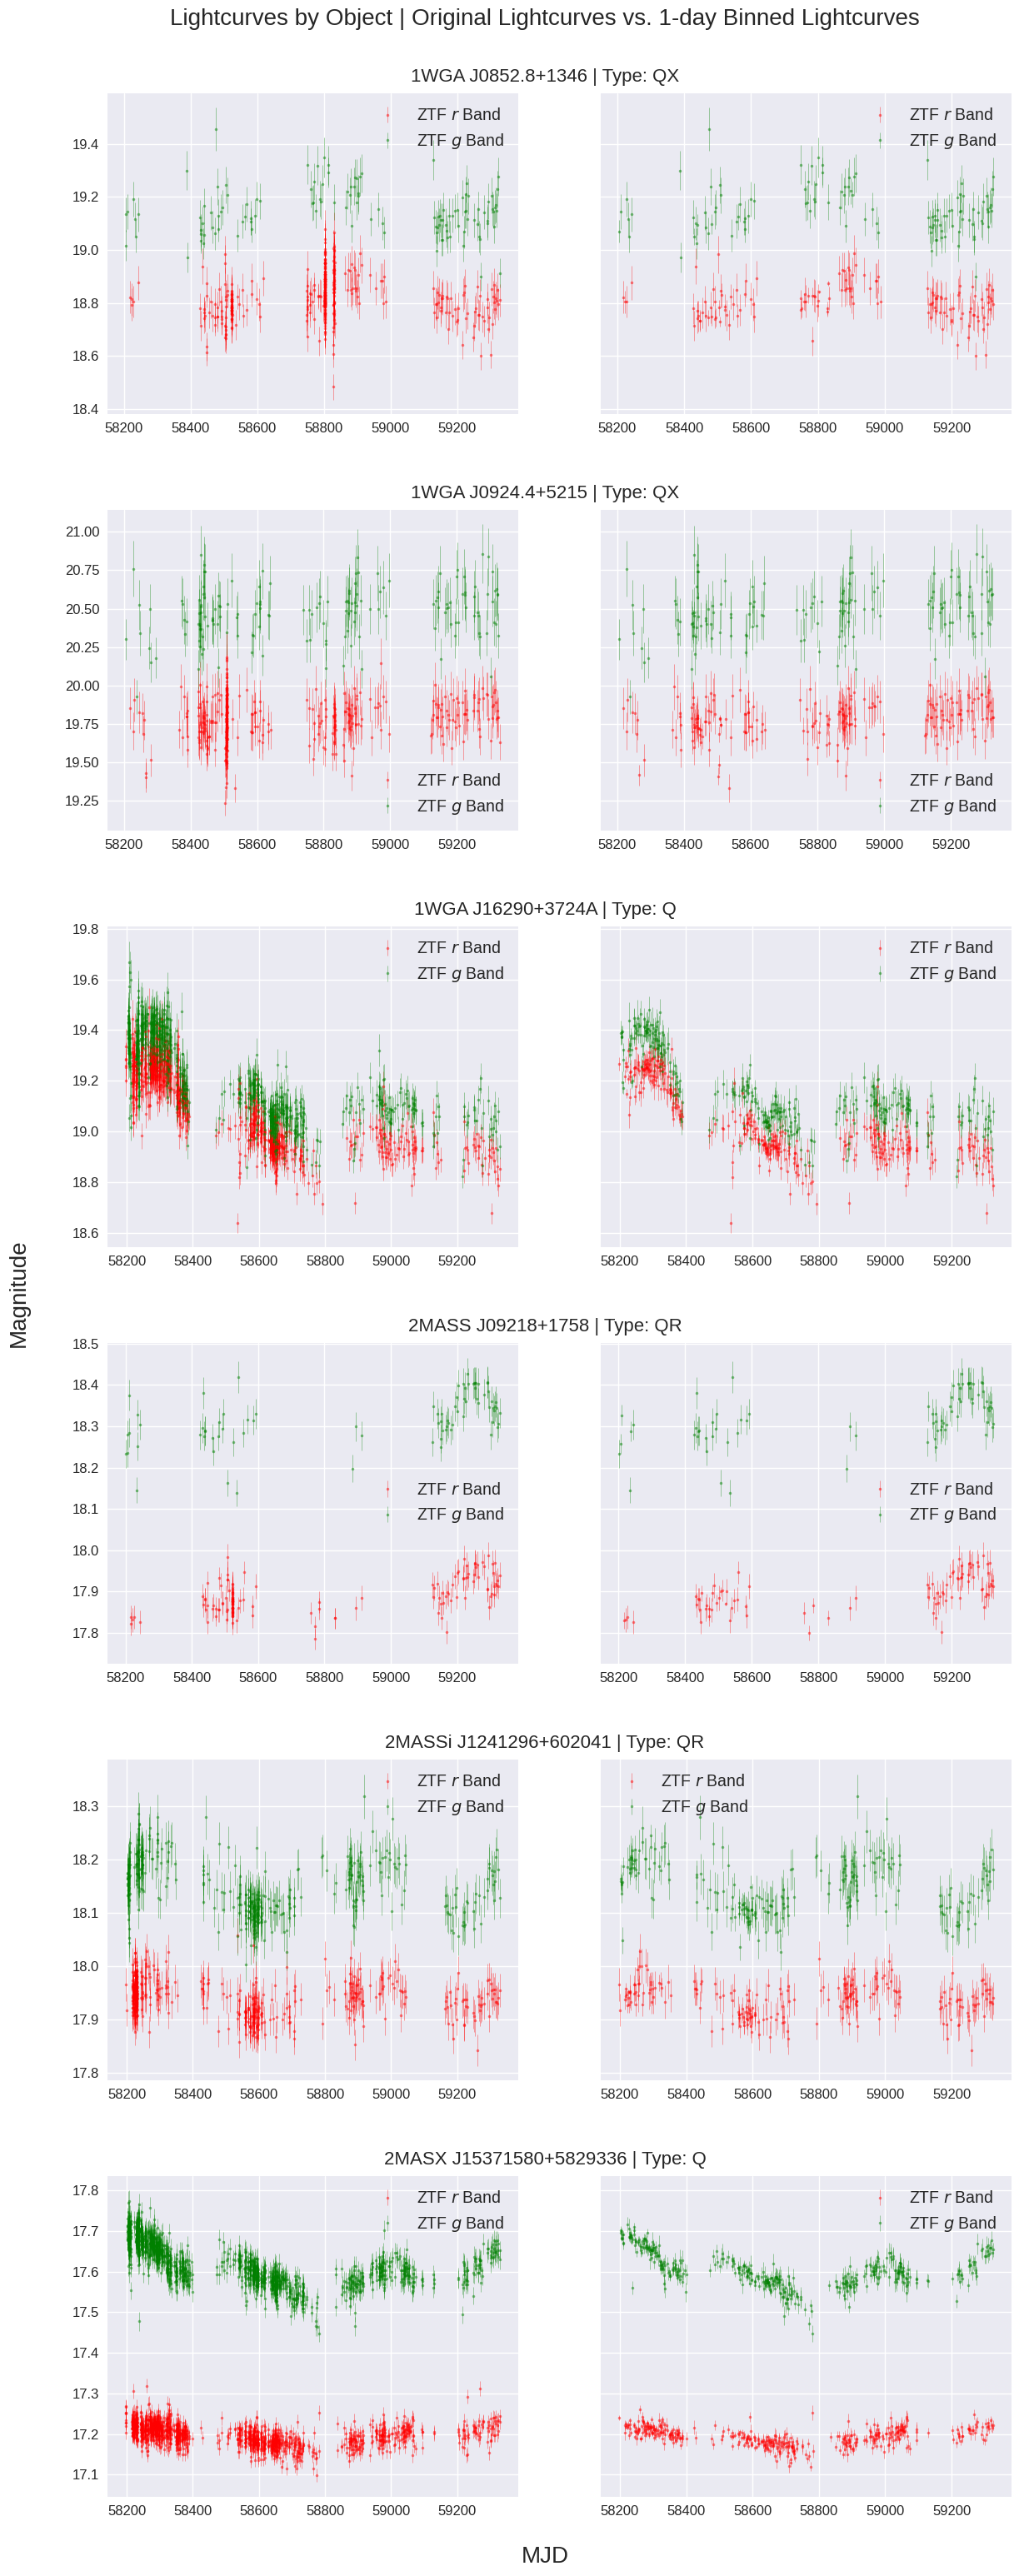

In [13]:
num_examples_per_type = 2
df = lightcurves_by_name.dropna(axis=0).query("type in @qso_types").groupby('type').head(num_examples_per_type).reset_index(drop=True)
num_examples = len(df)

fig = plt.figure(figsize=(14, 5 * num_examples))
subfigs = fig.subfigures(nrows=num_examples, ncols=1)

for subfig, (index, row) in zip(subfigs, df.iterrows()):
    object_name = row['name']
    object_type = row['type']
    title = f'{object_name} | Type: {object_type}'
    r_original_lightcurve, g_original_lightcurve = row['r_lightcurve'], row['g_lightcurve']
    r_1day_lightcurve, g_1day_lightcurve = row['r_lightcurve_1day'], row['g_lightcurve_1day']
    
    axs = plot_single_subfig(subfig, r_original_lightcurve, g_original_lightcurve, r_1day_lightcurve, g_1day_lightcurve, title)
    for ax in axs:
        ax.set_xlabel("")
        ax.set_ylabel("")
    
fig.suptitle('Lightcurves by Object | Original Lightcurves vs. 1-day Binned Lightcurves', size=20, y=1.014)
fig.supxlabel('MJD', size=20, y=-0.01)
fig.supylabel('Magnitude', size=20, x=0.04)

plt.subplots_adjust(hspace=0.)
plt.show()

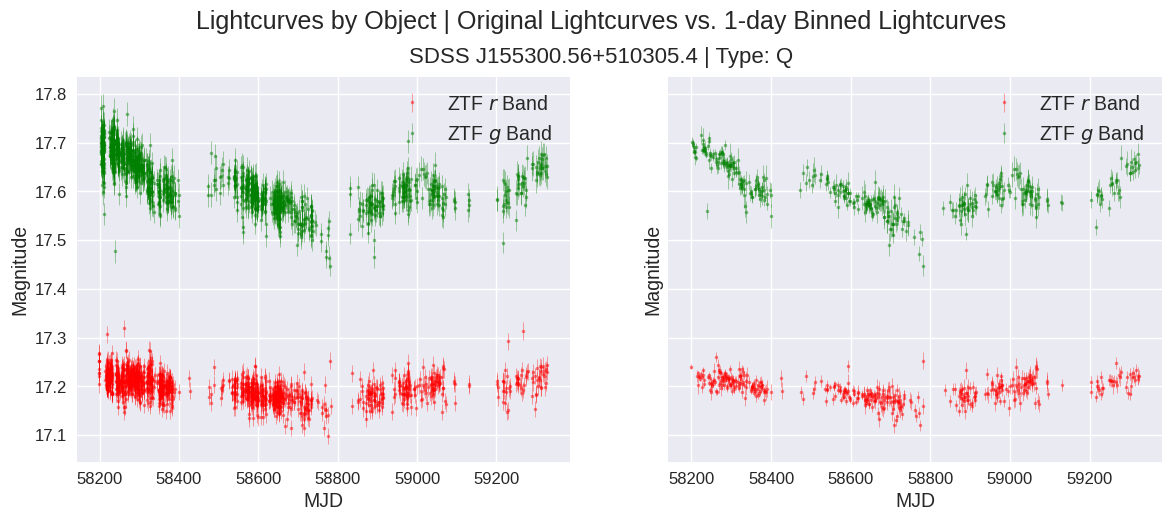

In [14]:
object_name = 'SDSS J155300.56+510305.4'
object_row = lightcurves_by_name.query("name == @object_name").reset_index(drop=True).iloc[0]

fig = plt.figure(figsize=(14, 5))
subfig = fig.subfigures(nrows=1, ncols=1)

object_type = row['type']

r_original_lightcurve, g_original_lightcurve = row['r_lightcurve'], row['g_lightcurve']
r_1day_lightcurve, g_1day_lightcurve = row['r_lightcurve_1day'], row['g_lightcurve_1day']

plot_single_subfig(subfig, r_original_lightcurve, g_original_lightcurve, r_1day_lightcurve, g_1day_lightcurve, title=f'{object_name} | Type: {object_type}')
    
fig.suptitle('Lightcurves by Object | Original Lightcurves vs. 1-day Binned Lightcurves', size=18, y=1.014)

plt.subplots_adjust(hspace=0.)
plt.show()

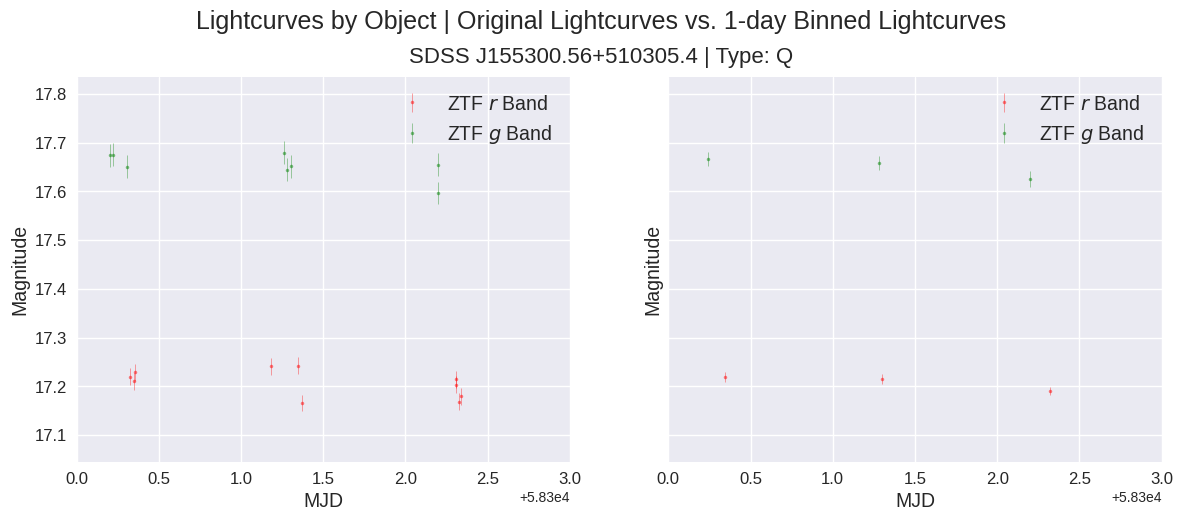

In [15]:
fig = plt.figure(figsize=(14, 5))
subfig = fig.subfigures(nrows=1, ncols=1)

object_type = row['type']

r_original_lightcurve, g_original_lightcurve = row['r_lightcurve'], row['g_lightcurve']
r_1day_lightcurve, g_1day_lightcurve = row['r_lightcurve_1day'], row['g_lightcurve_1day']

plot_single_subfig(subfig, r_original_lightcurve, g_original_lightcurve, r_1day_lightcurve, g_1day_lightcurve, title=f'{object_name} | Type: {object_type}')

axs = subfig.get_axes()
for ax in axs:
    ax.set_xlim(58300, 58303)
    
fig.suptitle('Lightcurves by Object | Original Lightcurves vs. 1-day Binned Lightcurves', size=18, y=1.014)

plt.subplots_adjust(hspace=0.)
plt.show()

In [16]:
lightcurves_by_name = lightcurves_by_name.drop(columns=['r_lightcurve', 'r_n_good_det', 'r_timespan_good', 'g_lightcurve', 'g_n_good_det', 'g_timespan_good'])
lightcurves_by_name = lightcurves_by_name.rename(columns={'r_lightcurve_1day': 'r_lightcurve',
                                                          'r_n_good_det_1day': 'r_n_good_det',
                                                          'r_timespan_good_1day': 'r_timespan_good',
                                                          'g_lightcurve_1day': 'g_lightcurve',
                                                          'g_n_good_det_1day': 'g_n_good_det',
                                                          'g_timespan_good_1day': 'g_timespan_good'})

lightcurves_by_name = lightcurves_by_name[['name', 'r_lightcurve', 'r_n_good_det', 'r_timespan_good', 'g_lightcurve', 'g_n_good_det', 'g_timespan_good']]
lightcurves_by_name.to_pickle(base_directory + 'lightcurves_by_name_1day_binned.pkl')

### Lightcurves by OID

In [17]:
interval = 1 # days

lightcurves_by_oid['lightcurve_1day'] = lightcurves_by_oid['lightcurve'].parallel_apply(lambda lc: apply_dayscale_binning(interval, lc))
lightcurves_by_oid['n_good_det_1day'] = lightcurves_by_oid['lightcurve_1day'].apply(lambda lc: lc.shape[0] if isinstance(lc, np.ndarray) else np.nan)
lightcurves_by_oid['timespan_good_1day'] = lightcurves_by_oid['lightcurve_1day'].apply(lambda lc: lc[:, 0].max() - lc[:, 0].min() if isinstance(lc, np.ndarray) else np.nan)

In [18]:
# lightcurves = pd.read_pickle(base_directory + 'lightcurves_by_oid_1day.pkl')

In [19]:
def plot_single_subfig_single_band(subfig, band, original_lightcurve, binned_lightcurve, title):
    subfig.suptitle(title, size=16, y=0.95)
    
    axs = subfig.subplots(nrows=1, ncols=2)
    draw_lightcurve(ax=axs[0], band=band, lightcurve=original_lightcurve)
    draw_lightcurve(ax=axs[1], band=band, lightcurve=binned_lightcurve)
    return axs

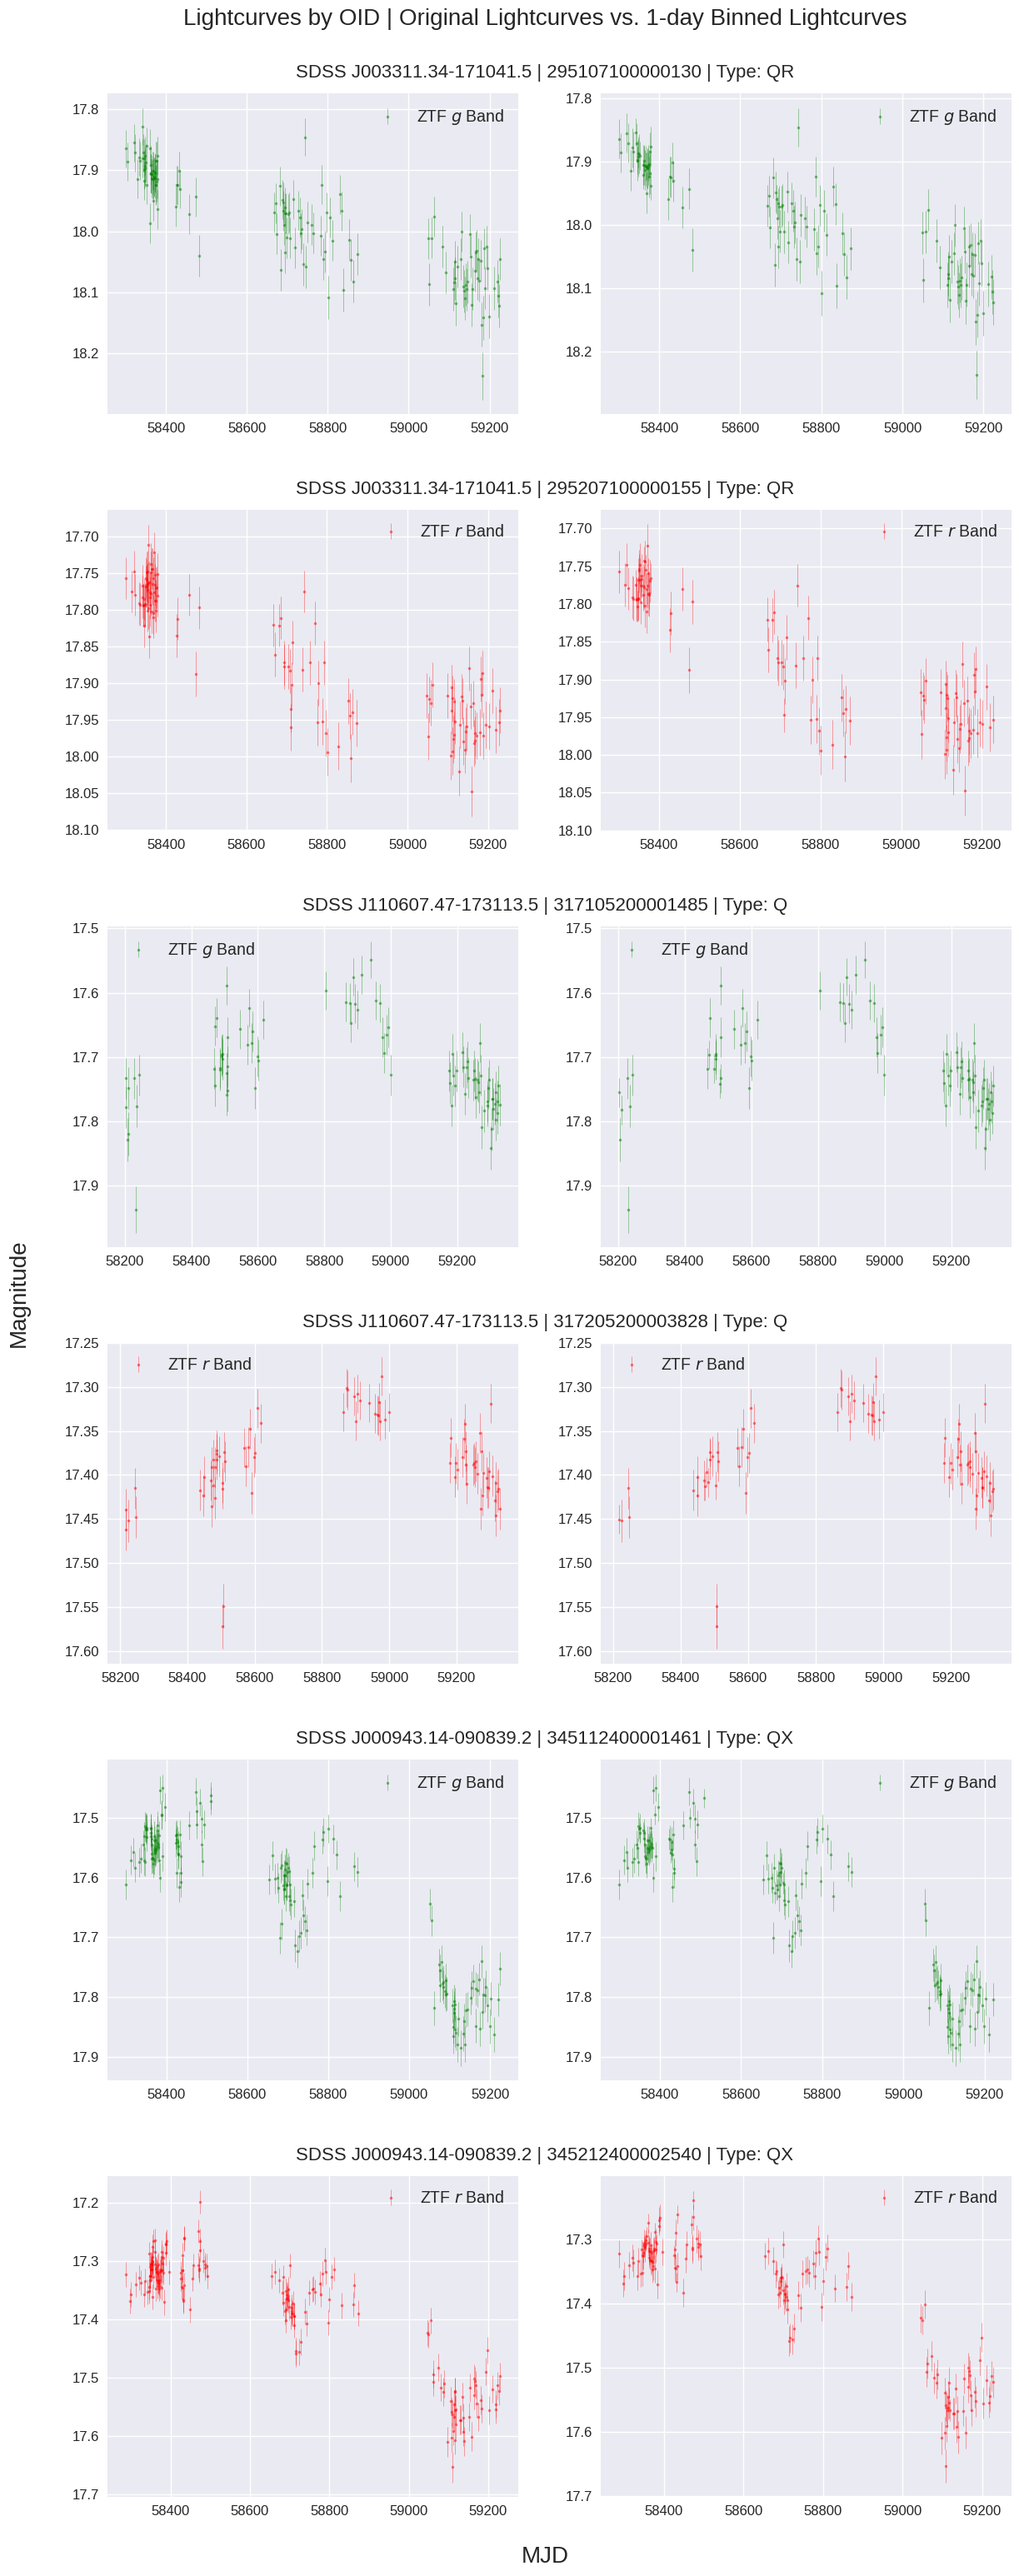

In [20]:
num_examples_per_type = 2
df = lightcurves_by_oid.dropna(axis=0).query("type in @qso_types").groupby('type').head(num_examples_per_type).reset_index(drop=True)
num_examples = len(df)

fig = plt.figure(figsize=(14, 5 * num_examples))
subfigs = fig.subfigures(nrows=num_examples, ncols=1)

for subfig, (index, row) in zip(subfigs, df.iterrows()):
    oid = row['oid_alerce']
    band = row['band']
    object_name = row['name']
    object_type = row['type']

    title = f'{object_name} | {oid} | Type: {object_type}'

    lightcurve_original = row['lightcurve']
    lightcurve_1day = row['lightcurve_1day']
    
    axs = plot_single_subfig_single_band(subfig, band, lightcurve_original, lightcurve_1day, title)
    for ax in axs:
        ax.set_xlabel("")
        ax.set_ylabel("")
    
fig.suptitle('Lightcurves by OID | Original Lightcurves vs. 1-day Binned Lightcurves', size=20, y=1.014)
fig.supxlabel('MJD', size=20, y=-0.01)
fig.supylabel('Magnitude', size=20, x=0.04)

plt.subplots_adjust(hspace=0.)
plt.show()

In [21]:
lightcurves_by_oid = lightcurves_by_oid.drop(columns=['lightcurve', 'n_good_det', 'timespan_good'])
lightcurves_by_oid = lightcurves_by_oid.rename(columns={'lightcurve_1day': 'lightcurve',
                                                        'n_good_det_1day': 'n_good_det',
                                                        'timespan_good_1day': 'timespan_good'})

lightcurves_by_oid = lightcurves_by_oid[['oid_alerce', 'lightcurve', 'n_good_det', 'timespan_good']]
lightcurves_by_oid.to_pickle(base_directory + 'lightcurves_by_oid_1day_binned.pkl')